# Content
- <a href='#1'>1. Introduction</a>
  - <a href='#1.1'>1.1 Intro to the Stock Market</a>
  - <a href='#1.2'>1.2 Motivation</a>
- <a href='#2'>2. Imports and Exploring Data</a>
  - <a href='#2.1'>2.1 Importing Libraries and Data</a>
  - <a href='#2.2'>2.2 Exploring the Data</a>
- <a href='#3'>3. Manipulating the Data</a>
  - <a href='#3.1'>3.1 Extracting the Right Features</a>
  - <a href='#3.2'>3.2 Relative Strength Index (RSI)</a>
  - <a href='#3.3'>3.3 Moving Average Convergence Divergence (MACD)</a>
  - <a href='#3.4'>3.4 Stochastic Oscillator</a>
  - <a href='#3.5'>3.5 Average True Range (ATR)<a/>
  - <a href='#3.6'>3.6 Creating the Training/Testing Data</a>
- <a href='#4'>4. The Neural Network</a>
   - <a href='#4.1'>4.1 Our Neural Network Architecture</a>
   - <a href='#4.2'>4.2 Saving our Model</a>

<hr>
# <a id='1'>1. Introduction</a>

### <a id='1.1'>1.1 Intro to the Stock Market</a>
The Stock Exchange is a global marketplace where a momentous amount of money is moved around each day. What people buy from the stock market are shares from a company. These shares represent ownership of a company so in essence, the more shares that you own, the more influence you'd have over a company. After we buy a share, we could also sell it back to other people to make some money!
[!](<iframe width="560" height="315" src="https://www.youtube.com/embed/F3QpgXBtDeo?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>)

In [2]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/F3QpgXBtDeo?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

After hearing all this you might be wondering, why isn't everyone just buying shares and getting rich and why do people make it seem so hard to get into trading stocks? It should be similar to if I was buying and selling off any old antique on Ebay.

Well... The thing is, the price of a share changes based on a wide variety of factors. These could include news, social media prescence and internal company happenings. Due to the huge variation of things that could affect any given stock, we may as well think of the price of a stock to change randomly. In fact, for many years it was believed that the changes in the stock market were completely random!

### <a id='1.2'>1.2 Motivation</a>

Many big financial comapnies, such as Goldman Sachs, invest millions of dollars on trying to come up with predictive models to help them make more informed investments. With the help of Machine Learning even regular people, like us, can come up with powerful predictive models that can help us make more informed investments of our own.

This Jupyter Notebook will go through how we can organize stock data from Yahoo Finance so that we can run a Recurrent Neural Network through the data to predict the future prices of a Google Stock.

<hr>
# <a id='2'>2. Imports and Exploring Data</a>
### <a id='2.1'>2.1 Importing Libraries and Data</a>

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Bidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
from sklearn.model_selection import train_test_split
%matplotlib inline

'''
from google.colab import files
uploaded = files.upload()
'''

'''
# GPU stuff
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

# Choose a style for our plots
# This style is clean
style.use('ggplot')

# Import our data and show how it looks
df = pd.read_csv('GOOGL.csv')
df.head()

Using TensorFlow backend.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3451,2018-05-04,1019.609985,1051.880005,1018.049988,1051.000000,1051.000000,1844600
3452,2018-05-07,1053.890015,1065.000000,1050.270020,1059.459961,1059.459961,1720000
3453,2018-05-08,1064.619995,1065.229980,1051.640015,1058.589966,1058.589966,1301500
3454,2018-05-09,1064.099976,1094.000000,1062.109985,1088.949951,1088.949951,2358000
3455,2018-05-10,1095.000000,1109.410034,1093.880005,1105.469971,1105.469971,1816600


### <a id='2.2'>2.2 Exploring the Data</a>

3456


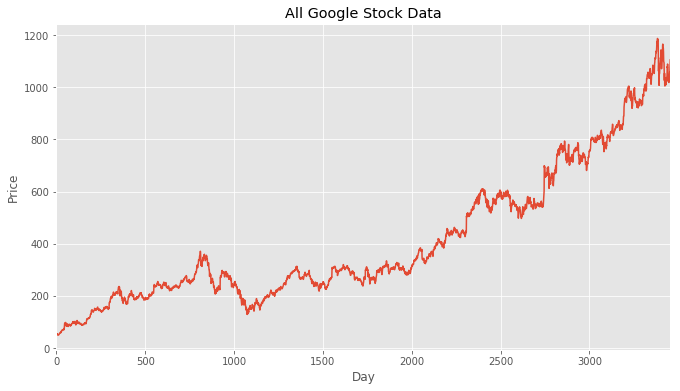

In [5]:
print(len(df))
# Since all of the data is correlated, except for volume
# we will only plot the Adj Close
plt.figure(figsize=(11,6))
df['Adj Close'].plot()
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('All Google Stock Data')
plt.show()

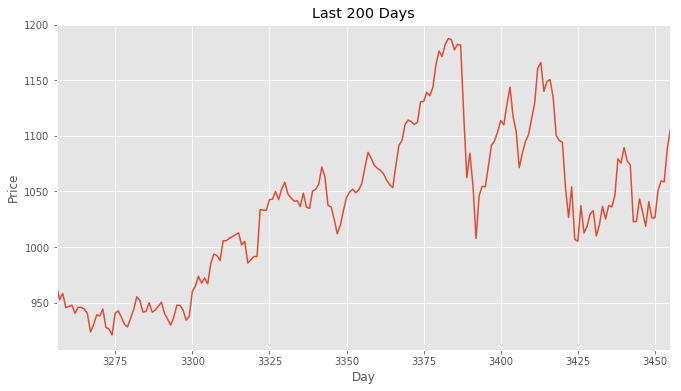

In [6]:
# Let's zoom in on the last 200 days to get a closer look
plt.figure(figsize=(11,6))
df['Adj Close'].iloc[-200:].plot()
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Last 200 Days')
plt.show()

<hr>
# <a id='3'>3. Manipulating the Data</a>
  ### <a id='3.1'>3.1 Extracting the Right Features</a>
  So now we've seen how the data looks. let's get to trimming out the unnecessary bits of information. For our dataset we'll only keep the Open and the Adj Close Prices. After that, we'll calculate the overall change in the stock price for that day. From there on we should be able to calculate some 'Technical Indicators' that could help us predict the movement of our stock.

In [7]:
# Let's add the Change, Gain and Loss
df['Change'] = df['Adj Close'] - df['Open']
df['Gain'] = (df['Change']).apply(lambda x: x if x>0 else 0)
df['Loss'] = (df['Change']).apply(lambda x: np.abs(x) if x<0 else 0)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Gain,Loss
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000,0.170170,0.170170,0.000000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300,3.653652,3.653652,0.000000
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100,-0.675678,0.000000,0.675678
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300,-3.188186,0.000000,3.188186
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600,0.520523,0.520523,0.000000


  ### <a id='3.2'>3.2 Relative Strength Index (RSI)</a>
  The first Technical Indicator we're going to add to our dataset is called the Relative Strength Index (RSI). What the RSI does is show the speed and change of price movements. This is represented by a value between 0 and 100, when the value is below 30 the stock is considered oversold and a value of 70 means that the stock is overbought. To calculate the RSI we have to use the following formula.
  
$$RSI = 100 - \frac{100}{1 + RS}$$

where....

$$RS = \frac{\text{Average Gain}}{\text{Average Loss}}$$

This Average Gain/Loss uses the following formula.

$$\text{Average Gain/Loss} = \frac{[(\text{previous Gain/Loss}) \times 13 + \text{Current Gain/Loss}]}{\text{period}}$$

The important thing to see here is that the calculations for the Average Gain/Loss use the previous Average Gain/Loss. The advantage of using this measure, is that the more data we have, the more accurate this indicator becomes. Perfect for when we're working with Big Data!

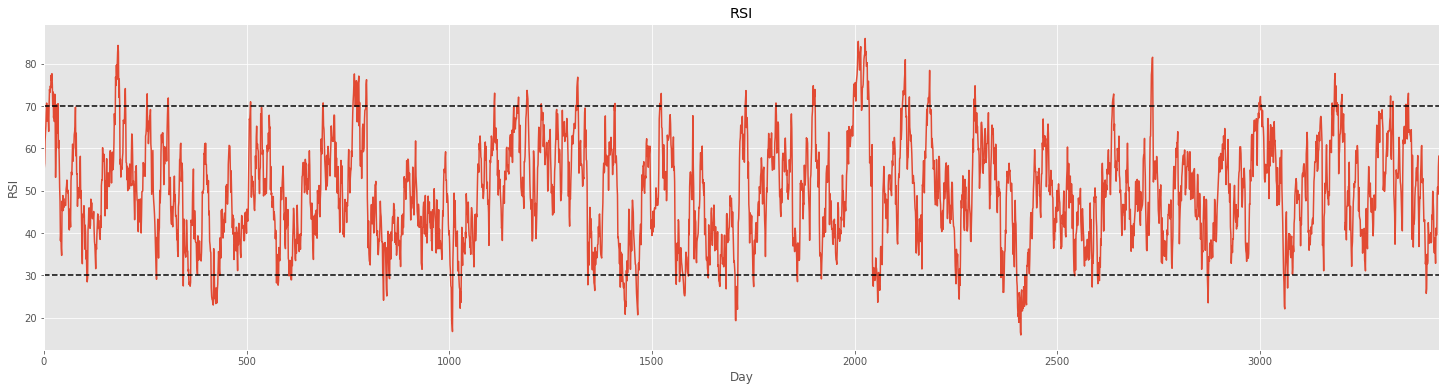

In [8]:
def RSI_calc(df, period):
  df = df.copy()
  
  first_avg_gain = np.sum(df['Gain'].iloc[:period]) / period
  first_avg_loss = np.sum(df['Loss'].iloc[:period]) / period
  
  # Each of these are indexed at df.iloc[period]
  avg_gain = [first_avg_gain]
  avg_loss = [first_avg_loss]
  
  # We need to start indexing at period+1
  for i in range(period+1, len(df)):
    avg_gain.append(((avg_gain[-1]*13) + df['Gain'].iloc[i]) / period)
    avg_loss.append(((avg_loss[-1]*13) + df['Loss'].iloc[i]) / period)
  
  avg_gain = pd.Series(avg_gain)
  avg_loss = pd.Series(avg_loss)
  
  RS = avg_gain / avg_loss
  
  RSI = 100 - (100 / (1 + RS))
  return RSI

plt.figure(figsize=(25, 6))
RSI_calc(df, 14).plot()
plt.axhline(70, linestyle='--', color='k')
plt.axhline(30, linestyle='--', color='k')
plt.title('RSI')
plt.xlabel('Day')
plt.ylabel('RSI')
plt.show()

  ### <a id='3.3'>3.3 Moving Average Convergence Divergence (MACD)</a>
  
  The second Technical Indicator we're going to use is the Moving Average Convergence Divergence (MACD). This is a very popular momentum oscillator. When the MACD has a positive value, that means that the stock is experiencing an upwards trend in price. Whereas, when it's negative it shows that the price is experiencing a downward trend. 
  
  To calculate the MACD we must first calculate a few Exponential Moving Averages (EMA) for a given period of days using the formula. If we use a shorter period of days, our EMA puts more emphasis on the most recent price, while a longer period puts less emphasis on the most recent days.
  
 $$EMA = [Close - \text{EMA(previous day)}] \times multiplier + \text{EMA(previous day)}$$
 
 
 $$multiplier = \frac{2}{period + 1}$$
 
  Then we use the EMA's as such to get our MACD value.
  
  $$\text{MACD Line} = \text{12-day EMA} - \text{26-day EMA}$$
  
  $$\text{Signal Line} = \text{9-day EMA}$$
  
  $$\text{MACD value} = \text{MACD Line} - \text{Signal Line}$$

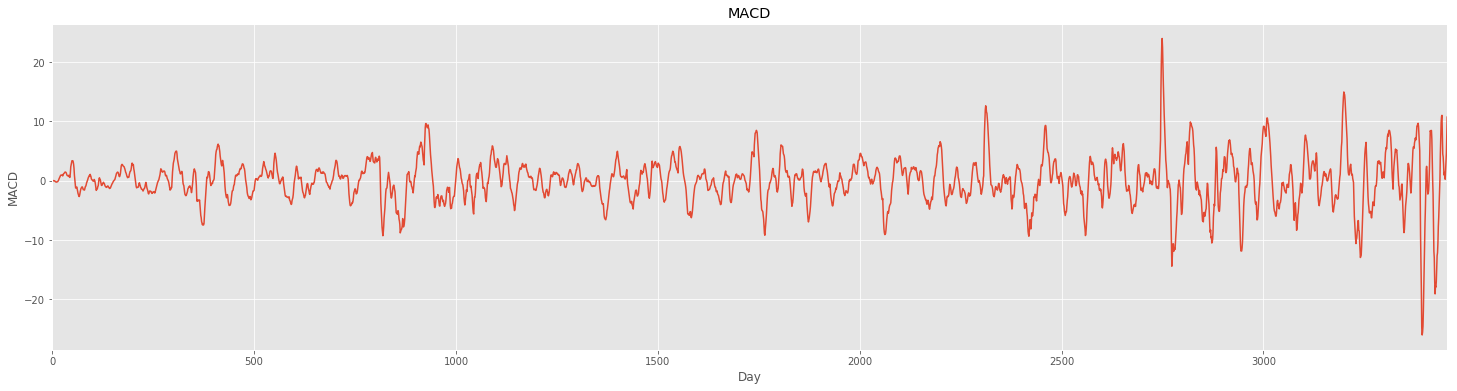

In [9]:
def MACD(df,period1,period2,periodSignal):
    EMA1 = pd.DataFrame.ewm(df['Adj Close'],span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df['Adj Close'],span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    Histogram = pd.DataFrame(Histogram)
    Histogram.rename(columns={'Adj Close':'MACD'}, inplace=True)
    
    return Histogram

plt.figure(figsize=(25, 6))
MACD(df, 12, 26, 9)['MACD'].plot()
plt.title('MACD')
plt.xlabel('Day')
plt.ylabel('MACD')
plt.show()

  ### <a id='3.4'>3.4 Stochastic Oscillator</a>
  The third Technical Indicator we're going to add to our model is the Stochastic Oscillator. The gist of this is indicator is that if a stock is experiencing an upward trend, it will close near it's highest price, but during a downward trend it will close near it's lowest price. This method is very effective for stocks that are more choppy while - let's say - the RSI is better for market that follows a trend. The MACD would fall somewhere in the middle since it uses short-term data.
  
  The calculation for the Stochastic Oscillator looks like this...
  
  $$\%K = \frac{\text{Current Close} - \text{Lowest Low}}{\text{Highest High} - \text{Lowest Low}} \times 100\%$$

The use of a Simple Moving Average it often used to show when you should make a transaction.

$$\%D = \text{3-day SMA of } \%K$$

Text(0,0.5,'Stochastic Value')

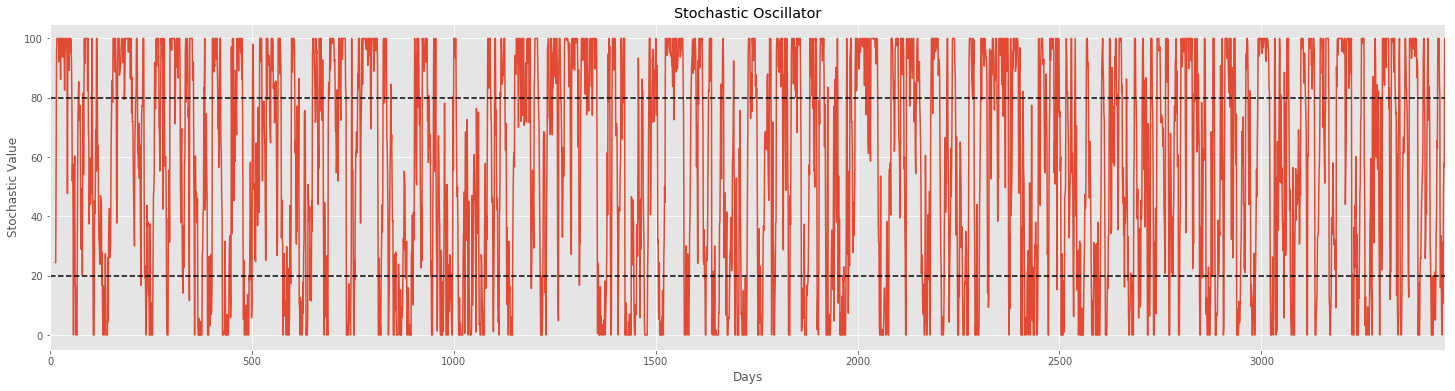

In [10]:
def stochastic(df, period):
    lows = pd.DataFrame.rolling(df['Adj Close'], period).min()
    highs = pd.DataFrame.rolling(df['Adj Close'], period).max()
    k = 100 * (df['Adj Close'] - lows) / (highs - lows)
    return k
  

# The plot looks kinda ugly, but it works!
plt.figure(figsize=(25, 6))
stochastic(df, 14).plot()
plt.title('Stochastic Oscillator')
plt.axhline(80, linestyle='--', color='k')
plt.axhline(20, linestyle='--', color='k')
plt.xlabel('Days')
plt.ylabel('Stochastic Value')


### <a id='3.5'>3.5 Average True Range (ATR)<a/>
  
The Average True Range is a measure of volatility. This picture shows 3 Methods of how to calculate it.

<img src='http://d.stockcharts.com/school/data/media/chart_school/technical_indicators_and_overlays/average_true_range_atr/atr-1-trexam.png'></img>

For our code we used Method A

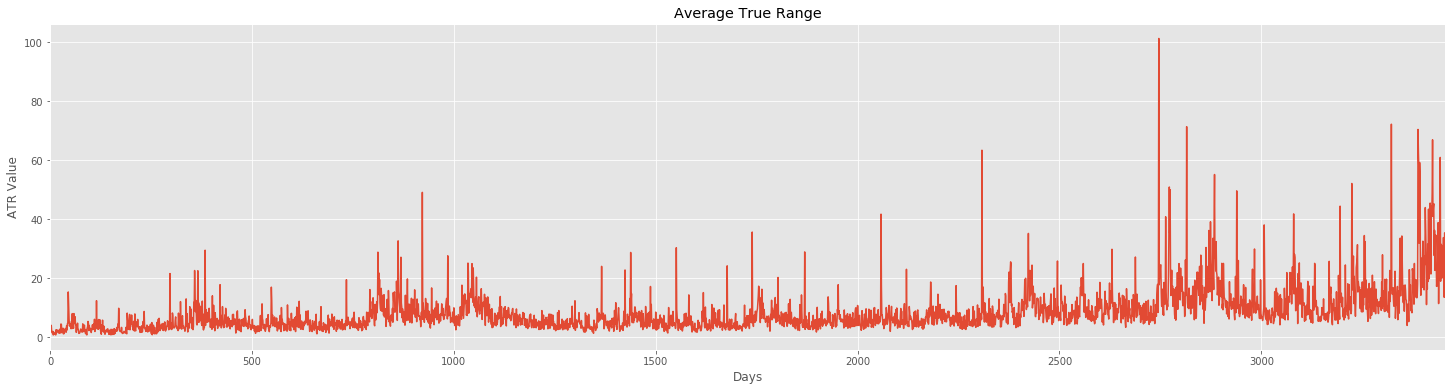

In [11]:
def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()
  
plt.figure(figsize=(25, 6))
ATR(df, 14)[0].plot()
plt.title('Average True Range')
plt.xlabel('Days')
plt.ylabel('ATR Value')
plt.show()

  ### <a id='3.6'>3.6 Creating the Training/Testing Data</a>

In [24]:
price = df[['Adj Close']].copy()
price['RSI'] = RSI_calc(df, 14)
price['RSI'] = price['RSI'].shift(14)
price['MACD'] = MACD(price, 12, 26, 9)
price['Stochastic'] = stochastic(price, 14)
price['ATR'] = ATR(df, 14)

# Normalize the data
price = (price - price.mean()) / (price.max() - price.min())

# Add in the target price
price['CloseTarget'] = price['Adj Close'].shift(-1)
dataset = price.dropna()

dataset.to_csv('Google_TechnicalIndicators.csv', index=False)
#files.download('Google_TechnicalIndicators.csv')
dataset

,Adj Close,RSI,MACD,Stochastic,ATR,CloseTarget
14,-0.319416,0.004254,-0.001952,-0.329933,-0.075441,-0.318087
15,-0.318087,0.083249,0.000312,-0.008315,-0.057738,-0.317132
16,-0.317132,0.100433,0.003052,0.373226,-0.068609,-0.315376
17,-0.315376,0.174144,0.007059,0.425125,-0.057988,-0.315152
18,-0.315152,0.197998,0.009853,0.425125,-0.063872,-0.314285
19,-0.314285,0.224409,0.012574,0.425125,-0.063274,-0.312737
20,-0.312737,0.270564,0.016076,0.425125,-0.064321,-0.311914
21,-0.311914,0.303392,0.019031,0.425125,-0.059883,-0.312583
22,-0.312583,0.242674,0.019458,0.346572,-0.069457,-0.312345
23,-0.312345,0.257641,0.019359,0.374480,-0.069706,-0.311271


# <a id='4'> The Neural Network</a>
So now that we have our dataset all ready to go, let's get to the fun part of building our model! The model we're going to use is a Recurrent Neural Network. The advantage of using a Recurrent Net is that they're built to predict the next value in time-series data. This means that if the order of our data matters, then Recurrent Neural Nets should perform really well on trying to predict the next values in our data. but first we need to split our data into training and testing sets

In [25]:
#Splitting the data into train and test sets
X = dataset[['Adj Close', 'RSI', 'MACD', 'Stochastic', 'ATR']]
Y = dataset[['CloseTarget']]

#Splits the data so that 10% of our data is saved for testing
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=int(len(X)*0.10), shuffle=False)

let's plot our training data and our testing data to get a sense of what we should expect to see

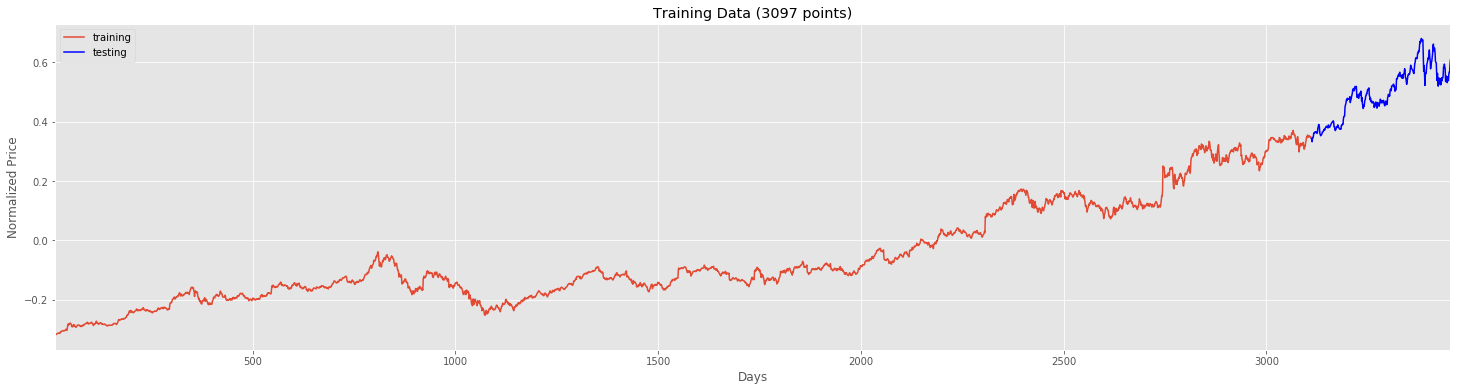

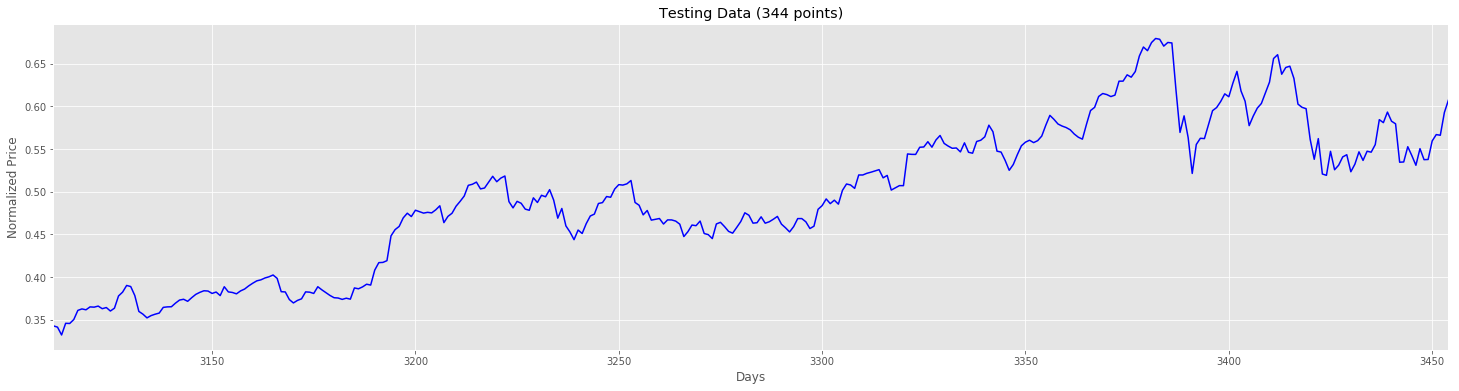

In [26]:
plt.figure(figsize=(25, 6))
trainY['CloseTarget'].plot(label='training')
testY['CloseTarget'].plot(label='testing', color='blue')
plt.title('Training Data ({} points)'.format(len(trainY)))
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(25, 6))
testY['CloseTarget'].plot(color='blue')
plt.title('Testing Data ({} points)'.format(len(testY)))
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.show()

In [27]:
# Hyperparameters
samples = len(trainX) # how many data points do we have
time_steps = 1 # how far do we look back in time
features = len(trainX.columns) # how many columns are in our training data
print(samples, time_steps, features)

# convert our pandas dataframes into matrices
trainX = trainX.as_matrix()
trainY = trainY.as_matrix()

3097 1 5


### <a id='4.1'>4.1 Our Neural Network Architecture</a>

The type of Neural Network we're going to use is a Recurrent Network. A Recurrent Network allows data from past values persist in the network. This allows it to be incredibly good at predicting values in sequence or time-series data, so data where the order of each point is important. This is perfect for stock data!

<img src='https://cdn-images-1.medium.com/max/1600/0*WdbXF_e8kZI1R5nQ.png'></img>

This new Recurrent Network sounds great and all but, there's one problem with them, as values persist in the network their influence on the model decreases over time. This is known as the vanishing gradient problem. To fix this we're going to use a special Recurrent Network called a Long-Short Term Memory (LSTM) Network. This solves the vanishing gradient problem by employing some clever math tricks that wont be explained for now.

Now let's get to building our model and training it!

In [28]:
# Our input data for an LSTM has to have the shape (samples, time_steps, feature)
trainX = trainX.reshape(samples, time_steps, features)
print(trainX.shape[1:])

(1, 5)


In [31]:
# Now let's build our model
model = Sequential()
model.add(LSTM(5, input_shape=trainX.shape[1:]))# LSTM layer with 5 nodes
model.add(Dense(5)) # Regular fully connected layer with 5 nodes
model.add(Dense(1)) # Output layer with 1 node to represent predicted price

# Mean Squared Error is a really good loss function for Regression problems
# The Adam optimizer is a stochastic gradient descent method with momentum
#     tldr: This is a popular optimizer, which will lead to rapid convergence
model.compile(loss='mean_squared_error', optimizer='adam')

# We'll train our model for 1000 epochs
# and it will take each point one at a time
performance = model.fit(trainX, trainY, epochs=250, batch_size=1)

Epoch 1/250
3097/3097 [==============================] - 10s 3ms/step - loss: 0.0034
Epoch 2/250
3097/3097 [==============================] - 9s 3ms/step - loss: 5.2275e-05
Epoch 3/250
3097/3097 [==============================] - 10s 3ms/step - loss: 6.0686e-05
Epoch 4/250
3097/3097 [==============================] - 7s 2ms/step - loss: 5.8684e-05
Epoch 5/250
3097/3097 [==============================] - 8s 2ms/step - loss: 5.5612e-05
Epoch 6/250
3097/3097 [==============================] - 8s 3ms/step - loss: 5.7184e-05
Epoch 7/250
3097/3097 [==============================] - 8s 3ms/step - loss: 5.5157e-05
Epoch 8/250
3097/3097 [==============================] - 11s 4ms/step - loss: 5.4566e-05
Epoch 9/250
3097/3097 [==============================] - 8s 3ms/step - loss: 5.3774e-05
Epoch 10/250
3097/3097 [==============================] - 8s 3ms/step - loss: 5.2865e-05
Epoch 11/250
3097/3097 [==============================] - 10s 3ms/step - loss: 5.5213e-05
Epoch 12/250
3097/3097 [======

3097/3097 [==============================] - 9s 3ms/step - loss: 4.2776e-05
Epoch 94/250
3097/3097 [==============================] - 9s 3ms/step - loss: 4.4200e-05
Epoch 95/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.3051e-05
Epoch 96/250
3097/3097 [==============================] - 7s 2ms/step - loss: 4.4753e-05
Epoch 97/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.3515e-05
Epoch 98/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.5576e-05
Epoch 99/250
3097/3097 [==============================] - 7s 2ms/step - loss: 4.3787e-05
Epoch 100/250
3097/3097 [==============================] - 7s 2ms/step - loss: 4.3054e-05
Epoch 101/250
3097/3097 [==============================] - 9s 3ms/step - loss: 4.1844e-05
Epoch 102/250
3097/3097 [==============================] - 8s 3ms/step - loss: 4.4526e-05
Epoch 103/250
3097/3097 [==============================] - 8s 3ms/step - loss: 4.4040e-05
Epoch 104/250
3097/3097 [=====

3097/3097 [==============================] - 5s 2ms/step - loss: 4.0338e-05
Epoch 185/250
3097/3097 [==============================] - 5s 2ms/step - loss: 4.0580e-05
Epoch 186/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.2357e-05
Epoch 187/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.1504e-05
Epoch 188/250
3097/3097 [==============================] - 7s 2ms/step - loss: 4.2065e-05
Epoch 189/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.0599e-05
Epoch 190/250
3097/3097 [==============================] - 7s 2ms/step - loss: 4.0917e-05
Epoch 191/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.0468e-05
Epoch 192/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.0759e-05
Epoch 193/250
3097/3097 [==============================] - 6s 2ms/step - loss: 3.9039e-05
Epoch 194/250
3097/3097 [==============================] - 6s 2ms/step - loss: 4.1464e-05
Epoch 195/250
3097/3097 

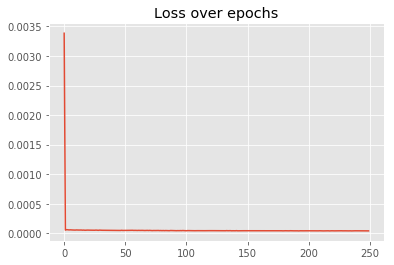

344/344 [==============================] - 0s 828us/step
0.000376746706487


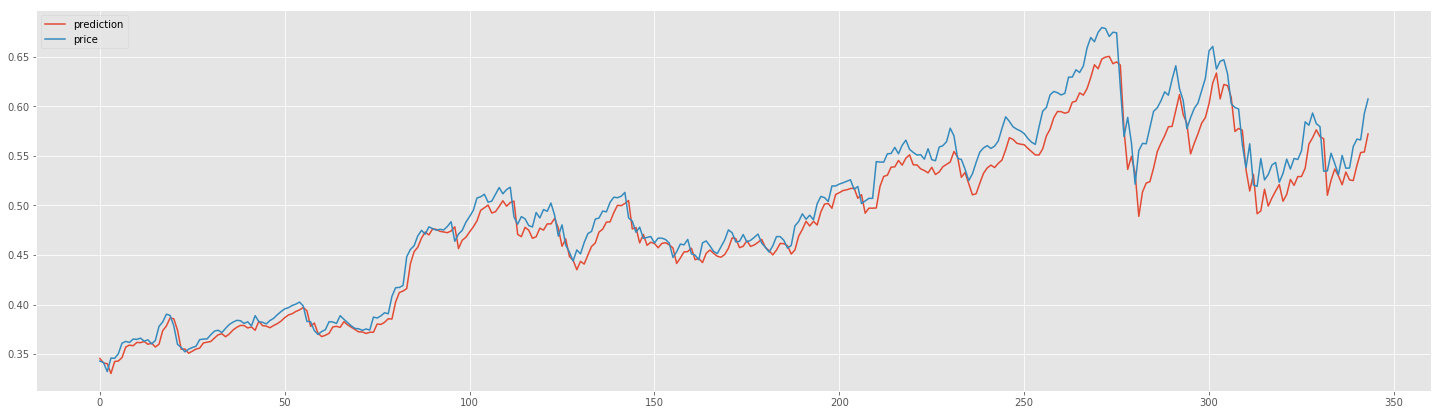

In [33]:
# Let's plot the loss and accuracy over the number of iterations
plt.figure()
plt.plot(performance.history['loss'])
plt.title('Loss over epochs')
plt.show()

# Now that we trained our model let's feed in the testing data
test_sample = len(testX)
testing = testX.as_matrix()

# reshape our testing data for the LSTM
testing = testing.reshape(test_sample, 1, 5)

score = model.evaluate(testing, testY.as_matrix(), batch_size=1)
print(score)
prediction = model.predict(testing)

# Let's plot our model's prediction against the test data
plt.figure(figsize=(25, 7))
plt.plot(list(range(len(prediction))), prediction, label='prediction')
plt.plot(list(range(len(testY))), testY, label='price')
plt.legend(loc='upper left')
plt.show()

As we can see our model's prediction get's really close to the testing data!

So now what, we fitted a model to match this line. From here if we were a large trading firm, we could try to test this model with a small amount of money and see how much profit it makes. After that, we could then decide whether we should deploy it for real heavy use. Also, we could see if it predicts well in a simulated environment.

### <a id='4.2'>4.2 Saving our Model</a>

We don't want to keep having to train our model all the time, so let's save our model. To do this we're going to use the keras method save() to save our model. Then to load our model we're going to import load_model() from keras.

In [34]:
model.save('my_model.h5')

Now we should have a file on our computer that stores our model. If we ever decided to load the model at a later time then we can load it using the load_model() function.

344/344 [==============================] - 0s 1ms/step
Our current loaded model's score: 0.000376746706487


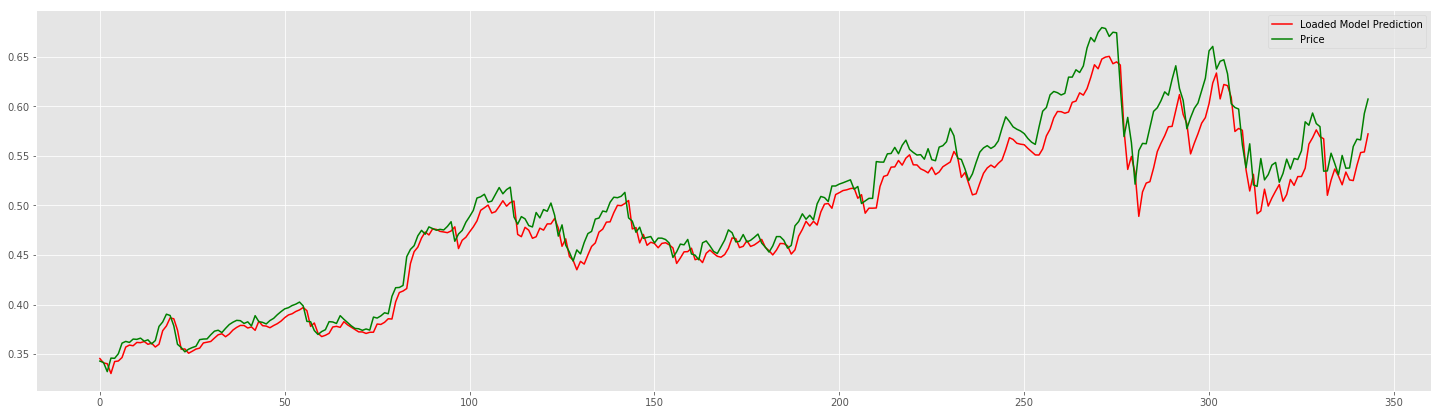

In [35]:
from keras.models import load_model

# Load our model from the saved file
model2 = load_model('my_model.h5') # trained for 150 epochs
score2 = model2.evaluate(testing, testY.as_matrix(), batch_size=1)
print("Our current loaded model's score:", score2)

# Let's plot the prediction of the loaded model
# to demonstrate that it still works
plt.figure(figsize=(25, 7))
plt.plot(range(len(testing)), model2.predict(testing), color='red', label='Loaded Model Prediction')
plt.plot(range(len(testing)), testY.as_matrix(), color='green', label='Price')
plt.legend()
plt.show()